In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import nltk

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [31]:
import tweepy
from tweepy import OAuthHandler

In [32]:
consumer_key='lEnDMCgGt1M5kxbEu7V81JXfN'
consumer_secret='fGSv3N3krgbNlxIxdjB0yOtvOW7Od7N3eOAbQWgt2n9rzCRboa'
access_token_key='843918897204023296-4eZrkwkJifvbcihIHnWug5Ualx6uv2s'
access_token_secret='StSVLidH4Tk3HfDCHz94WgoeuzBqvUUJzTlXfdmbdt1wh'

In [33]:
auth = OAuthHandler(consumer_key,consumer_secret) #to authenticate whether it is twitter application or not.

In [34]:
auth.set_access_token(access_token_key,access_token_secret) #to enable the rights to fetch tweets from twitter

In [35]:
args = ['Tesla Cybertruck']

In [36]:
api = tweepy.API(auth,timeout=10000) # if we don't find any tweets, after 10000 seconds it will stop looking for tweets.

In [37]:
list_tweets1 = [] #it will contain all the tweets

In [38]:
query = args[0] #to convert args into strings

Cursor:- A class in the tweepy library which is used to fetch the tweets.

We are also filtering the retweets.(If we don't, we'll get same tweets over and over again.)

Language = english

result_type='recent' - We are fetching the most recent tweets.

items = The number of tweets we want.

In [39]:
if len(args) == 1:
    for status in tweepy.Cursor(api.search, q=query+" -filter:retweets",lang='en',
                               result_type='recent',tweet_mode='extended',
                               wait_on_rate_limit=True).items(5000):
        list_tweets1.append(status.full_text)
        time.sleep(1)

In [172]:
df = pd.DataFrame({'Tweets':list_tweets1})

In [173]:
df.head()

,Tweets
0,"Alright guys listen up, so here’s the story be..."
1,@WeArePlayground Can you add Tesla's cybertruck?
2,"A Hit Or Not,Tesla’s Very Weird New Cybertruck..."
3,yeah we could go to a restaurant or something ...
4,@ElonsWorld @Tesla @elonmusk A classic ( horse...


In [174]:
#df.to_csv('cyber_truck.csv',index=False)

## Data Preprocessing

## Removing '@' patterns

In [175]:
def remove_pattern(column, pattern):
    r = re.findall(pattern, column)
    for i in r:
        column = re.sub(i, '', column)
        
    return column 

In [176]:
df['Tweets'] = np.vectorize(remove_pattern)(df.Tweets, "@[\w]*")

## Removing the links

In [177]:
list2 = []

In [178]:
for i in range(0,len(df.Tweets)):
    list2.append(' '.join(word for word in df.Tweets[i].split(' ') if not word.startswith('https')))

In [179]:
df['Tweets']=list2

## Removing Punctuations, Numbers, and Special Characters

In [180]:
df['Tweets'] = df['Tweets'].str.replace("[^a-zA-Z#]", " ")

## Removing Short Words

In [181]:
df['Tweets'] = df['Tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

## Changing the text to lower case

In [182]:
df['Tweets'] = df['Tweets'].apply(lambda x:x.lower())

## Tokenization

In [183]:
tokenized_tweet = df['Tweets'].apply(lambda x:nltk.word_tokenize(x))
tokenized_tweet.head()

0    [alright, guys, listen, up, so, here, the, sto...
1                   [can, you, add, tesla, cybertruck]
2    [hit, or, not, tesla, very, weird, new, cybert...
3    [yeah, we, could, go, to, restaurant, or, some...
4    [classic, horse, is, always, classic, hopefull...
Name: Tweets, dtype: object

## Lemmatization

In [184]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [185]:
wnl = WordNetLemmatizer()

In [186]:
tokenized_tweet.apply(lambda x: [wnl.lemmatize(i) for i in x if i not in set(stopwords.words('english'))]) 
tokenized_tweet.head()

0    [alright, guys, listen, up, so, here, the, sto...
1                   [can, you, add, tesla, cybertruck]
2    [hit, or, not, tesla, very, weird, new, cybert...
3    [yeah, we, could, go, to, restaurant, or, some...
4    [classic, horse, is, always, classic, hopefull...
Name: Tweets, dtype: object

In [187]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

In [188]:
df['Tweets'] = tokenized_tweet

In [189]:
df.head()

,Tweets
0,alright guys listen up so here the story behin...
1,can you add tesla cybertruck
2,hit or not tesla very weird new cybertruck
3,yeah we could go to restaurant or something la...
4,classic horse is always classic hopefully some...


## Sentiment Analysis

In [190]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [191]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [192]:
df['Sentiment_Scores'] = df['Tweets'].apply(lambda x:sia.polarity_scores(x)['compound'])

In [193]:
df.head()

,Tweets,Sentiment_Scores
0,alright guys listen up so here the story behin...,0.2500
1,can you add tesla cybertruck,0.0000
2,hit or not tesla very weird new cybertruck,0.1864
3,yeah we could go to restaurant or something la...,0.0516
4,classic horse is always classic hopefully some...,0.5106


## Classifying the Sentiment scores as Positive, Negative and Neutral

In [194]:
df['Sentiment'] = df['Sentiment_Scores'].apply(lambda s : 'Positive' if s > 0 else ('Neutral' if s == 0 else 'Negative'))

In [195]:
df.head()

,Tweets,Sentiment_Scores,Sentiment
0,alright guys listen up so here the story behin...,0.2500,Positive
1,can you add tesla cybertruck,0.0000,Neutral
2,hit or not tesla very weird new cybertruck,0.1864,Positive
3,yeah we could go to restaurant or something la...,0.0516,Positive
4,classic horse is always classic hopefully some...,0.5106,Positive


## Let's Contstruct a wordcloud of all the tweets to see the most frequent tweets.

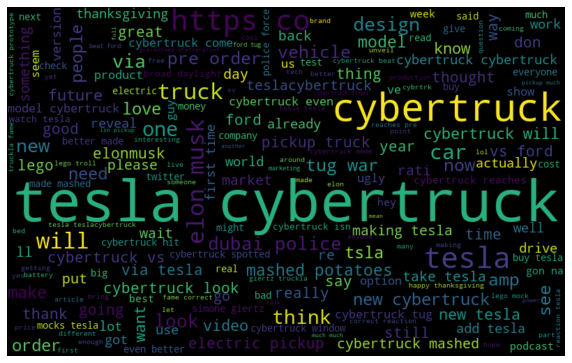

In [196]:
all_words = ' '.join([text for text in df['Tweets']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Let's Contstruct a wordcloud to see the most frequent positive tweets.

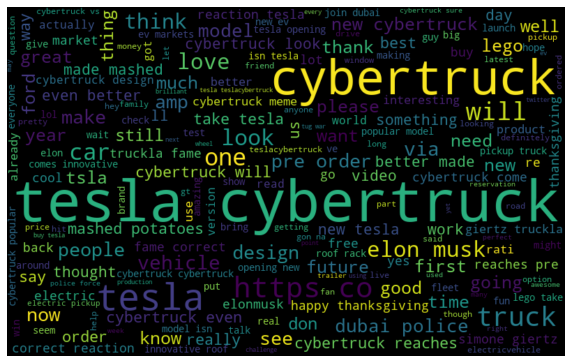

In [198]:
all_words = ' '.join([text for text in df['Tweets'][df.Sentiment == 'Positive']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Let's Contstruct a wordcloud to see the most frequent negative tweets.

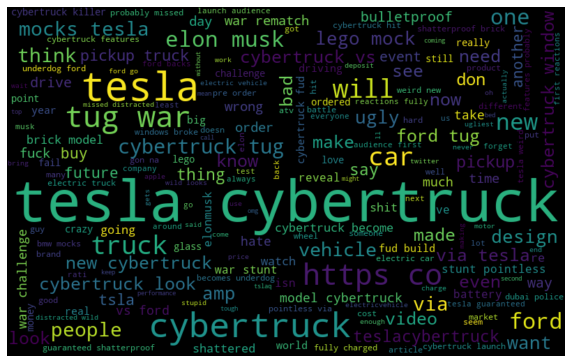

In [199]:
all_words = ' '.join([text for text in df['Tweets'][df.Sentiment == 'Negative']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()